In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# All  Necessary Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 20
batch_size = 64
learning_rate = 1e-3


In [0]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

In [0]:
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [0]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [0]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# Start training
t = time.time()
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconstruction Loss: {:.4f}, KL Divergence: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

elapsed = time.time() - t
print("Training Takes {} seconds".format(elapsed))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20], Step [10/938], Reconstruction Loss: 18407.2812, KL Divergence: 1500.0900
Epoch[1/20], Step [20/938], Reconstruction Loss: 15081.2598, KL Divergence: 607.1226
Epoch[1/20], Step [30/938], Reconstruction Loss: 13397.5508, KL Divergence: 693.4001
Epoch[1/20], Step [40/938], Reconstruction Loss: 12872.6602, KL Divergence: 303.7212
Epoch[1/20], Step [50/938], Reconstruction Loss: 14244.0000, KL Divergence: 340.8522
Epoch[1/20], Step [60/938], Reconstruction Loss: 12740.5645, KL Divergence: 454.7859
Epoch[1/20], Step [70/938], Reconstruction Loss: 12440.0254, KL Divergence: 389.9010
Epoch[1/20], Step [80/938], Reconstruction Loss: 12106.4453, KL Divergence: 614.0410
Epoch[1/20], Step [90/938], Reconstruction Loss: 11423.2930, KL Divergence: 584.7109
Epoch[1/20], Step [100/938], Reconstruction Loss: 12452.1943, KL Divergence: 553.8268
Epoch[1/20], Step [110/938], Reconstruction Loss: 11614.8740, KL Divergence: 692.5308
Epoch[1/20], Step [120/938], Reconstruction Loss: 10313.9229, 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(-0.5, 27.5, 27.5, -0.5)

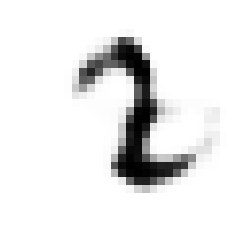

In [0]:
# Testing
# Generate an image from random noise
eval_model = model.eval()     
with torch.no_grad():
    # Random noise
    z = torch.randn(1, z_dim).to(device)
    # Decode
    out = eval_model.decode(z).view(-1, 1, 28, 28)

sampled_img = torch.squeeze(torch.squeeze(out,dim=0),dim=0)
plt.imshow(sampled_img)
plt.axis('off')